# Artificial Intelligence Nanodegree

## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [3]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2023 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

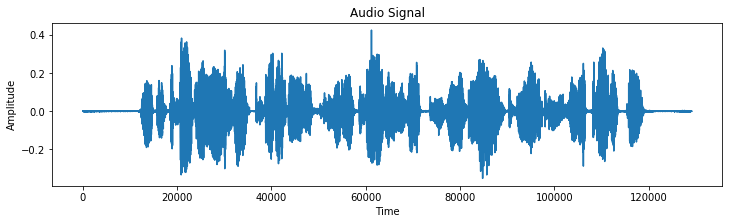

**Shape of Audio Signal** : (129103,)

**Transcript** : mister quilter is the apostle of the middle classes and we are glad to welcome his gospel

In [4]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

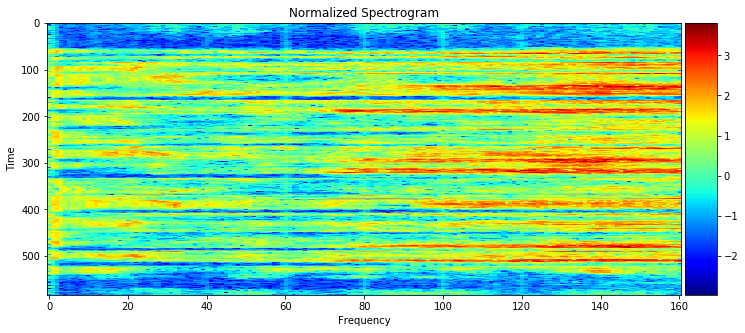

**Shape of Spectrogram** : (584, 161)

In [5]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

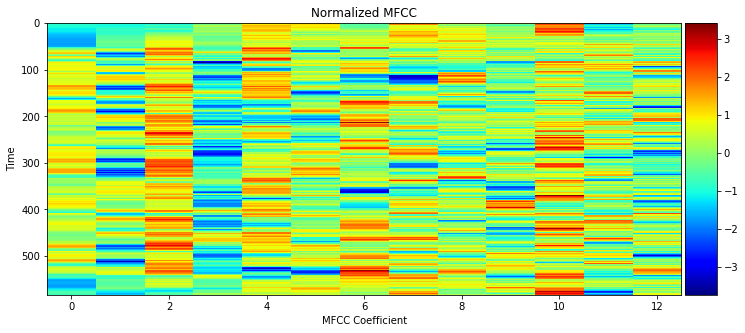

**Shape of MFCC** : (584, 13)

In [6]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [1]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

Using TensorFlow backend.


<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [2]:
model_0 = simple_rnn_model(input_dim=161) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


In [3]:
# model_0_MFCC
model_5 = simple_rnn_model(input_dim=13) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          3741      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 3,741
Trainable params: 3,741
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [4]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_00.pickle', 
            save_model_path='model_00.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 102s - loss: 864.1874 - val_loss: 757.3234
Epoch 2/20
101/101 [==============================] - 95s - loss: 779.5043 - val_loss: 759.0025
Epoch 3/20
101/101 [==============================] - 96s - loss: 779.2768 - val_loss: 758.6686
Epoch 4/20
101/101 [==============================] - 96s - loss: 779.3604 - val_loss: 754.8821
Epoch 5/20
101/101 [==============================] - 96s - loss: 778.8613 - val_loss: 759.3568
Epoch 6/20
101/101 [==============================] - 96s - loss: 778.8896 - val_loss: 752.8145
Epoch 7/20
101/101 [==============================] - 96s - loss: 778.5261 - val_loss: 760.0025
Epoch 8/20
101/101 [==============================] - 96s - loss: 778.6260 - val_loss: 756.4978
Epoch 9/20
101/101 [==============================] - 96s - loss: 778.0397 - val_loss: 758.6431
Epoch 10/20
101/101 [==============================] - 97s - loss: 778.4657 - val_loss: 757.5047
Epoch 11/20
101/101 [=================

In [5]:
train_model(input_to_softmax=model_5, 
            pickle_path='model_05.pickle', 
            save_model_path='model_05.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 118s - loss: 844.7741 - val_loss: 756.5164
Epoch 2/20
101/101 [==============================] - 118s - loss: 779.8697 - val_loss: 754.6907
Epoch 3/20
101/101 [==============================] - 118s - loss: 779.5394 - val_loss: 757.0411
Epoch 4/20
101/101 [==============================] - 118s - loss: 779.3539 - val_loss: 760.0657
Epoch 5/20
101/101 [==============================] - 118s - loss: 779.1906 - val_loss: 755.8095
Epoch 6/20
101/101 [==============================] - 118s - loss: 778.8590 - val_loss: 759.1230
Epoch 7/20
101/101 [==============================] - 118s - loss: 779.4043 - val_loss: 762.1452
Epoch 8/20
101/101 [==============================] - 118s - loss: 779.3051 - val_loss: 750.3370
Epoch 9/20
101/101 [==============================] - 119s - loss: 778.7515 - val_loss: 762.4472
Epoch 10/20
101/101 [==============================] - 119s - loss: 778.7232 - val_loss: 751.7580
Epoch 11/20
101/101 [========

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [6]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,829
Trainable params: 223,429
Non-trainable params: 400
_________________________________________________________________
None


In [7]:
# model_1_MFCC
model_6 = rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         128400    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 135,029
Trainable params: 134,629
Non-trainable params: 400
_________________________________________________________________
None


In [8]:
# model_1_lstm
model_7 = rnn_lstm_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (LSTM)                   (None, None, 200)         289600    
_________________________________________________________________
bn_rnn_1d (BatchNormalizatio (None, None, 200)         800       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 296,229
Trainable params: 295,829
Non-trainable params: 400
_________________________________________________________________
None


In [9]:
# model_1_MFCC_lstm 
model_8 = rnn_lstm_model(input_dim=13, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn (LSTM)                   (None, None, 200)         171200    
_________________________________________________________________
bn_rnn_1d (BatchNormalizatio (None, None, 200)         800       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 177,829
Trainable params: 177,429
Non-trainable params: 400
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [10]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_01.pickle', 
            save_model_path='model_01.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 310s - loss: 288.8989 - val_loss: 221.7127
Epoch 2/20
101/101 [==============================] - 325s - loss: 209.6925 - val_loss: 197.8439
Epoch 3/20
101/101 [==============================] - 337s - loss: 188.5242 - val_loss: 181.1655
Epoch 4/20
101/101 [==============================] - 341s - loss: 172.8677 - val_loss: 167.8289
Epoch 5/20
101/101 [==============================] - 344s - loss: 161.9367 - val_loss: 166.0439
Epoch 6/20
101/101 [==============================] - 347s - loss: 154.3362 - val_loss: 156.4349
Epoch 7/20
101/101 [==============================] - 345s - loss: 148.6304 - val_loss: 152.5467
Epoch 8/20
101/101 [==============================] - 348s - loss: 144.2690 - val_loss: 151.9242
Epoch 9/20
101/101 [==============================] - 346s - loss: 140.6614 - val_loss: 147.7642
Epoch 10/20
101/101 [==============================] - 349s - loss: 138.3682 - val_loss: 148.0342
Epoch 11/20
101/101 [========

In [11]:
train_model(input_to_softmax=model_6, 
            pickle_path='model_06.pickle', 
            save_model_path='model_06.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 327s - loss: 323.9934 - val_loss: 327.1841
Epoch 2/20
101/101 [==============================] - 333s - loss: 222.7937 - val_loss: 214.4790
Epoch 3/20
101/101 [==============================] - 330s - loss: 197.3200 - val_loss: 201.5031
Epoch 4/20
101/101 [==============================] - 332s - loss: 182.1573 - val_loss: 185.8124
Epoch 5/20
101/101 [==============================] - 332s - loss: 170.5046 - val_loss: 166.8809
Epoch 6/20
101/101 [==============================] - 334s - loss: 160.8913 - val_loss: 160.3671
Epoch 7/20
101/101 [==============================] - 334s - loss: 153.5951 - val_loss: 154.7605
Epoch 8/20
101/101 [==============================] - 331s - loss: 147.2455 - val_loss: 148.8043
Epoch 9/20
101/101 [==============================] - 332s - loss: 141.9904 - val_loss: 146.5948
Epoch 10/20
101/101 [==============================] - 335s - loss: 138.0238 - val_loss: 145.8839
Epoch 11/20
101/101 [========

In [12]:
train_model(input_to_softmax=model_7, 
            pickle_path='model_07.pickle', 
            save_model_path='model_07.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 284s - loss: nan - val_loss: nan
Epoch 2/20
101/101 [==============================] - 290s - loss: nan - val_loss: nan
Epoch 3/20
101/101 [==============================] - 294s - loss: nan - val_loss: nan
Epoch 4/20
101/101 [==============================] - 291s - loss: nan - val_loss: nan
Epoch 5/20
101/101 [==============================] - 292s - loss: nan - val_loss: nan
Epoch 6/20
101/101 [==============================] - 291s - loss: nan - val_loss: nan
Epoch 7/20
101/101 [==============================] - 290s - loss: nan - val_loss: nan
Epoch 8/20
101/101 [==============================] - 290s - loss: nan - val_loss: nan
Epoch 9/20
101/101 [==============================] - 289s - loss: nan - val_loss: nan
Epoch 10/20
101/101 [==============================] - 292s - loss: nan - val_loss: nan
Epoch 11/20
101/101 [==============================] - 291s - loss: nan - val_loss: nan
Epoch 12/20
101/101 [====================

In [13]:
train_model(input_to_softmax=model_8, 
            pickle_path='model_08.pickle', 
            save_model_path='model_08.h5',
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 262s - loss: nan - val_loss: nan
Epoch 2/20
101/101 [==============================] - 265s - loss: nan - val_loss: nan
Epoch 3/20
101/101 [==============================] - 266s - loss: nan - val_loss: nan
Epoch 4/20
101/101 [==============================] - 266s - loss: nan - val_loss: nan
Epoch 5/20
101/101 [==============================] - 262s - loss: nan - val_loss: nan
Epoch 6/20
101/101 [==============================] - 263s - loss: nan - val_loss: nan
Epoch 7/20
101/101 [==============================] - 263s - loss: nan - val_loss: nan
Epoch 8/20
101/101 [==============================] - 264s - loss: nan - val_loss: nan
Epoch 9/20
101/101 [==============================] - 262s - loss: nan - val_loss: nan
Epoch 10/20
101/101 [==============================] - 264s - loss: nan - val_loss: nan
Epoch 11/20
101/101 [==============================] - 265s - loss: nan - val_loss: nan
Epoch 12/20
101/101 [====================

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [14]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [15]:
# model_2_MFCC 
model_9 = cnn_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [16]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_02.pickle', 
            save_model_path='model_02.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 118s - loss: nan - val_loss: nan
Epoch 2/20
101/101 [==============================] - 117s - loss: nan - val_loss: nan
Epoch 3/20
101/101 [==============================] - 121s - loss: nan - val_loss: nan
Epoch 4/20
101/101 [==============================] - 120s - loss: nan - val_loss: nan
Epoch 5/20
101/101 [==============================] - 119s - loss: nan - val_loss: nan
Epoch 6/20
101/101 [==============================] - 119s - loss: nan - val_loss: nan
Epoch 7/20
101/101 [==============================] - 120s - loss: nan - val_loss: nan
Epoch 8/20
101/101 [==============================] - 119s - loss: nan - val_loss: nan
Epoch 9/20
101/101 [==============================] - 119s - loss: nan - val_loss: nan
Epoch 10/20
101/101 [==============================] - 119s - loss: nan - val_loss: nan
Epoch 11/20
101/101 [==============================] - 120s - loss: nan - val_loss: nan
Epoch 12/20
101/101 [====================

In [17]:
train_model(input_to_softmax=model_9, 
            pickle_path='model_09.pickle', 
            save_model_path='model_09.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 125s - loss: 243.9299 - val_loss: 200.5588
Epoch 2/20
101/101 [==============================] - 121s - loss: 183.4250 - val_loss: 172.9312
Epoch 3/20
101/101 [==============================] - 121s - loss: 156.0160 - val_loss: 153.9812
Epoch 4/20
101/101 [==============================] - 121s - loss: 143.3665 - val_loss: 145.1621
Epoch 5/20
101/101 [==============================] - 121s - loss: 135.1705 - val_loss: 140.3636
Epoch 6/20
101/101 [==============================] - 122s - loss: 129.3702 - val_loss: 138.1285
Epoch 7/20
101/101 [==============================] - 121s - loss: 124.4948 - val_loss: 135.9148
Epoch 8/20
101/101 [==============================] - 121s - loss: 120.6189 - val_loss: 133.8453
Epoch 9/20
101/101 [==============================] - 121s - loss: 116.9593 - val_loss: 133.1118
Epoch 10/20
101/101 [==============================] - 121s - loss: 114.9947 - val_loss: 130.2189
Epoch 11/20
101/101 [========

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [18]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn0 (GRU)                   (None, None, 200)         217200    
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
rnn1 (GRU)                   (None, None, 200)         240600    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [19]:
# model_3_MFCC 
model_10 = deep_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
rnn0 (GRU)                   (None, None, 200)         128400    
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
rnn1 (GRU)                   (None, None, 200)         240600    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [20]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_03.pickle', 
            save_model_path='model_03.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 923s - loss: 377.4610 - val_loss: 287.3889
Epoch 2/20
101/101 [==============================] - 1095s - loss: 239.5159 - val_loss: 208.5038
Epoch 3/20
101/101 [==============================] - 1207s - loss: 195.4944 - val_loss: 190.0269
Epoch 4/20
101/101 [==============================] - 1219s - loss: 167.5430 - val_loss: 163.4513
Epoch 5/20
101/101 [==============================] - 1243s - loss: 152.6519 - val_loss: 158.0880
Epoch 6/20
101/101 [==============================] - 1265s - loss: 143.8680 - val_loss: 149.5557
Epoch 7/20
101/101 [==============================] - 1275s - loss: 136.3293 - val_loss: 145.8326
Epoch 8/20
101/101 [==============================] - 1292s - loss: 130.2290 - val_loss: 140.6092
Epoch 9/20
101/101 [==============================] - 1291s - loss: 127.8525 - val_loss: 141.6496
Epoch 10/20
101/101 [==============================] - 1288s - loss: 124.1719 - val_loss: 143.2164
Epoch 11/20
101/101 

In [21]:
train_model(input_to_softmax=model_10, 
            pickle_path='model_10.pickle', 
            save_model_path='model_10.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 1472s - loss: 288.0224 - val_loss: 250.4642
Epoch 2/20
101/101 [==============================] - 1522s - loss: 235.1063 - val_loss: 217.0450
Epoch 3/20
101/101 [==============================] - 1532s - loss: 223.8304 - val_loss: 213.7911
Epoch 4/20
101/101 [==============================] - 1556s - loss: 209.8977 - val_loss: 199.2860
Epoch 5/20
101/101 [==============================] - 1564s - loss: 179.2658 - val_loss: 182.3658
Epoch 6/20
101/101 [==============================] - 1608s - loss: 161.1743 - val_loss: 158.4437
Epoch 7/20
101/101 [==============================] - 1596s - loss: 151.5545 - val_loss: 151.6625
Epoch 8/20
101/101 [==============================] - 1597s - loss: 143.3570 - val_loss: 147.7884
Epoch 9/20
101/101 [==============================] - 1621s - loss: 137.9078 - val_loss: 145.1255
Epoch 10/20
101/101 [==============================] - 1612s - loss: 134.0508 - val_loss: 142.0937
Epoch 11/20
101/101

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [22]:
from sample_models import *
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         434400    
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 446,029
Trainable params: 446,029
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# model_4_MFCC 
model_11 = bidirectional_rnn_model(input_dim=13, # change to 13 if you would like to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         256800    
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 268,429
Trainable params: 268,429
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [24]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_04.pickle', 
            save_model_path='model_04.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 1652s - loss: 293.0550 - val_loss: 228.5475
Epoch 2/20
101/101 [==============================] - 1708s - loss: 218.0729 - val_loss: 204.9271
Epoch 3/20
101/101 [==============================] - 1735s - loss: 204.9411 - val_loss: 195.2124
Epoch 4/20
101/101 [==============================] - 1704s - loss: 194.9247 - val_loss: 187.7707
Epoch 5/20
101/101 [==============================] - 1734s - loss: 186.3315 - val_loss: 180.1220
Epoch 6/20
101/101 [==============================] - 1729s - loss: 178.3508 - val_loss: 177.5956
Epoch 7/20
101/101 [==============================] - 1743s - loss: 170.5732 - val_loss: 168.1268
Epoch 8/20
101/101 [==============================] - 1734s - loss: 164.0298 - val_loss: 164.0918
Epoch 9/20
101/101 [==============================] - 1750s - loss: 157.9444 - val_loss: 162.8904
Epoch 10/20
101/101 [==============================] - 1753s - loss: 153.0005 - val_loss: 160.0728
Epoch 11/20
101/101

In [25]:
train_model(input_to_softmax=model_11, 
            pickle_path='model_11.pickle', 
            save_model_path='model_11.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 1428s - loss: 288.4817 - val_loss: 215.9277
Epoch 2/20
101/101 [==============================] - 1469s - loss: 213.3372 - val_loss: 198.9461
Epoch 3/20
101/101 [==============================] - 1478s - loss: 200.0183 - val_loss: 191.1099
Epoch 4/20
101/101 [==============================] - 1458s - loss: 190.4856 - val_loss: 184.3469
Epoch 5/20
101/101 [==============================] - 1440s - loss: 182.9214 - val_loss: 175.6907
Epoch 6/20
101/101 [==============================] - 1451s - loss: 175.6825 - val_loss: 167.7265
Epoch 7/20
101/101 [==============================] - 1454s - loss: 168.5047 - val_loss: 164.8962
Epoch 8/20
101/101 [==============================] - 1430s - loss: 162.3615 - val_loss: 159.3845
Epoch 9/20
101/101 [==============================] - 1430s - loss: 156.7255 - val_loss: 156.9239
Epoch 10/20
101/101 [==============================] - 1529s - loss: 151.2781 - val_loss: 152.7157
Epoch 11/20
101/101

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

In [26]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.
model_12 = deep_bdrnn_model(input_dim=161,# change to 13 if you would like to use MFCC features
                            units=200,
                            recur_layers=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 400)         434400    
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [27]:
train_model(input_to_softmax=model_12, 
            pickle_path='model_12.pickle', 
            save_model_path='model_12.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 4203s - loss: 297.7750 - val_loss: 267.6762
Epoch 2/20
101/101 [==============================] - 4830s - loss: 237.7767 - val_loss: 208.1296
Epoch 3/20
101/101 [==============================] - 4966s - loss: 198.7458 - val_loss: 186.2593
Epoch 4/20
101/101 [==============================] - 5004s - loss: 168.0864 - val_loss: 161.2971
Epoch 5/20
101/101 [==============================] - 5195s - loss: 149.5471 - val_loss: 159.5787
Epoch 6/20
101/101 [==============================] - 5135s - loss: 136.7204 - val_loss: 143.5785
Epoch 7/20
101/101 [==============================] - 5454s - loss: 126.6671 - val_loss: 137.1937
Epoch 8/20
101/101 [==============================] - 5449s - loss: 118.2044 - val_loss: 133.1574
Epoch 9/20
101/101 [==============================] - 5556s - loss: 111.4454 - val_loss: 130.7656
Epoch 10/20
101/101 [==============================] - 5556s - loss: 105.5514 - val_loss: 129.0066
Epoch 11/20
101/101

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

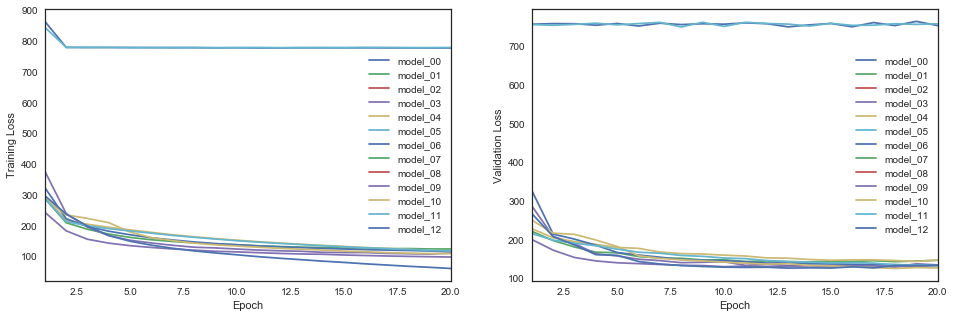

In [2]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__
As it was written above, "The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window. Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset". So, my first desire is to check the difference between implementations of spectrogram and MFCC features, as well the time of training and model overfitting. That is why I've checked both of them for each given model.

The graphs are grouped in two main groups here. Let's consider each of them more closely:

In [3]:
# Simple "for" loop to plot the interested graphs
def for_loop(ax,start,end,loss):
    for i in range(start,end):
        ax.plot(np.linspace(1, num_epochs[i], num_epochs[i]),
                loss[i], label=model_names[i])
        ax.legend()  
        ax.set_xlim([1, max(num_epochs)])
    
# Just to make it easy to plot
def plot_graph(start_1,end_1,start_2,end_2,y1_label,y2_label):
    fig = plt.figure(figsize=(16,5))

    # plot the training loss vs. epoch for each model
    ax1 = fig.add_subplot(121)
    plt.cla()

    for_loop(ax1,start_1,end_1,train_loss)
    for_loop(ax1,start_2,end_2,train_loss)

    # clean up the plot
    plt.xlabel('Epoch')
    plt.ylabel(y1_label)

    # plot the validation loss vs. epoch for each model
    ax2 = fig.add_subplot(122)

    for_loop(ax2,start_1,end_1,valid_loss)
    for_loop(ax2,start_2,end_2,valid_loss)

    # clean up the plot
    plt.xlabel('Epoch')
    plt.ylabel(y2_label)
    plt.show()

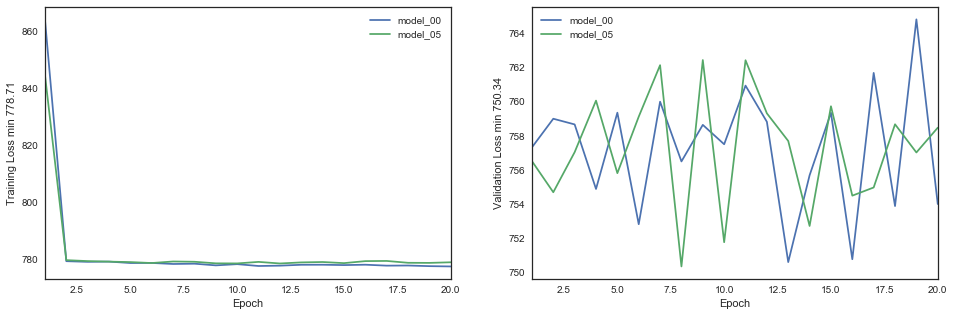

In [4]:
plot_graph(0,1,5,6,'Training Loss min {0:.2f}'.format(min(train_loss[5])),
          'Validation Loss min {0:.2f}'.format(min(valid_loss[5])))

We can see that the model_0 with both implementations gives us the worst result: it fails to pick up patterns in the data and has high training and validation losses. It means, that just a simple RNN is not an acceptable model for the given sequential data. We have to use **TimeDistributed** layer to apply fully connected **Dense** on each time step and get output separately by timesteps.

Let's continue with the second group:

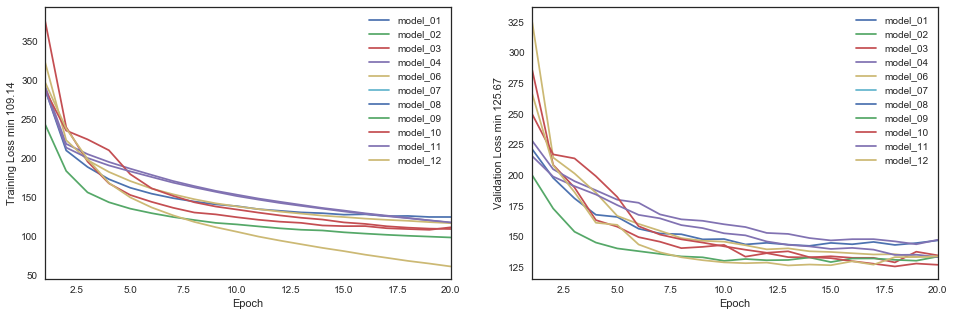

In [19]:
plot_graph(1,5,6,len(all_pickles),'Training Loss min {0:.2f}'.format(min(train_loss[10])),
          'Validation Loss min {0:.2f}'.format(min(valid_loss[10])))

**First**, we approved the statement, that SimpleRNN (in model_2 with Spectrogram features) and LSTM (in models 7 (Spectrogram) and 8 (MFCC)) usage leads to gradient explosion and demands additional tuning. However, when I changed the spectrogram feature for MFCC in the model_2 it gave me the acceptable result.

So, the **second**, I'll not take into account models with the exploded gradient.
For all others, and this is the **third**, I'll get the minimum of each model loss:

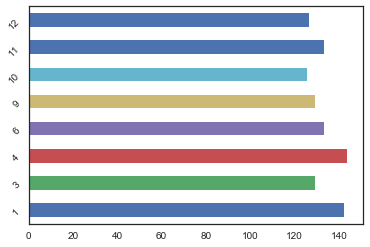

In [20]:
import pandas as pd

# Create the dictionary with the minimum of each model loss
dic_min = {}
for i in range(len(valid_loss)):
    dic_min[i] = min(valid_loss[i])
    
# Transform the data into pandas object for the next depiction    
loss_min = pd.Series(dic_min,index=dic_min.keys())

# Exclude the NAN data of models 2,7,8
loss_min = loss_min.dropna()

# Exclude the model_0 data
useful_cols = [1, 3, 4, 6, 9, 10, 11, 12]
loss_min = loss_min[useful_cols]
loss_min.plot(kind='barh',rot=45)

Great! I see, that the model_10 gave me the best result. The model_12 is in the second place. Let's plot them for the further consideration.

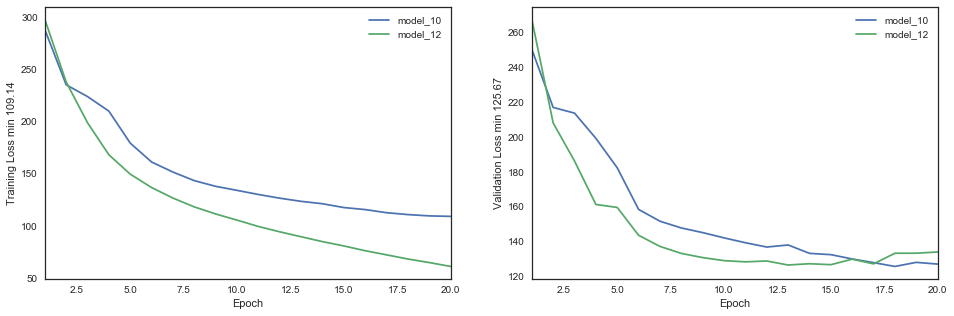

In [21]:
plot_graph(10,11,len(all_pickles)-1,len(all_pickles),'Training Loss min {0:.2f}'.format(min(train_loss[10])),
          'Validation Loss min {0:.2f}'.format(min(valid_loss[10])))

Now, if we'll compare the time of training, we'll see, that for the model_10 it is comparable with the other models, that gave the worse result, and much better compared to the model_12.

The last point which voting for the model_10 is no overfitting, which means that the model has some potential for developing.

From another hand, the model_12 (deep bidirectional) is learning much quicker, so the addition of **dropout** layer could give us a better result.

__Conclusion:__

1. The simple RNN is not an acceptable model for the given sequential data and demands additional techniques to implement.
2. The RNN with GRU works good, but failed with LSTM for the given data - the loss quickly becomes undefined (nan) due to the exploding gradients problem. Nevertheless, this [paper](https://arxiv.org/pdf/1412.3555v1.pdf) demonstrates the superiority of gated networks (GRU and LSTM) over a simple RNN but clearly mentions that it cannot conclude which of the either are better.
3. The CNN+RNN model uses additional CNN layer before RNN layer. This allows us to analyse Spectogram or MFCC features with convolutional kernels and to take into account only important features. 
4. The Deep RNN Network is made to use the advantages of DNN: many RNN layers. This strategy showed the best results of all models tested.
5. Bidirectional RNNs are based on the idea that the output at time t may not only depend on the previous elements in the sequence, but also future elements. They are just two RNNs stacked on top of each other. The output is then computed based on the hidden state of both RNNs. BRNN are especially useful when the context of the input is needed.
6. Deep (Bidirectional) RNNs are similar to Bidirectional RNNs, only that we now have multiple layers per time step. In practice, this gives us a higher learning capacity (but we also need a lot of training data and to spend a loooot of time to train). The overfitting occurred here should be avoided by additional technique (i.e. dropout).
7. Models with Spectrogram features gave the worse results and trained a little slower than with MFCC features.

<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [2]:
from sample_models import *

# specify the model
model_end_first = final_model(input_dim=13,# change to 13 if you would like to use MFCC features
                            units=200,
                            recur_layers=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         256800    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 400)         0         
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 400)         0         
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 400)         1600      
__________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_end_first, 
            pickle_path='model_end_first.pickle', 
            save_model_path='model_end_first.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 2618s - loss: 316.2229 - val_loss: 240.5645
Epoch 2/20
101/101 [==============================] - 3697s - loss: 228.0591 - val_loss: 268.5197
Epoch 3/20
101/101 [==============================] - 4281s - loss: 202.4814 - val_loss: 198.1109
Epoch 4/20
101/101 [==============================] - 4757s - loss: 187.5527 - val_loss: 176.9796
Epoch 5/20
101/101 [==============================] - 5076s - loss: 176.7351 - val_loss: 163.5448
Epoch 6/20
101/101 [==============================] - 5643s - loss: 167.5844 - val_loss: 154.0253
Epoch 7/20
101/101 [==============================] - 6273s - loss: 159.7266 - val_loss: 145.9565
Epoch 8/20
101/101 [==============================] - 7021s - loss: 152.9029 - val_loss: 142.5671
Epoch 9/20
101/101 [==============================] - 7556s - loss: 146.9919 - val_loss: 137.2461
Epoch 10/20
101/101 [==============================] - 7851s - loss: 142.6198 - val_loss: 134.4155
Epoch 11/20
101/101

In [5]:
from sample_models import *

# specify the model
model_end_conv_bidir = final_model(input_dim=161,
                                   filters=200,
                                   kernel_size=11, 
                                   conv_stride=2,
                                   conv_border_mode='valid',
                                   units=200,
                                   recur_layers=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 400)         1600      
__________

In [6]:
train_model(input_to_softmax=model_end_conv_bidir, 
            pickle_path='model_end_conv_bidir.pickle', 
            save_model_path='model_end_conv_bidir.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 1002s - loss: 280.3591 - val_loss: 239.1980
Epoch 2/20
101/101 [==============================] - 1060s - loss: 237.6006 - val_loss: 215.8481
Epoch 3/20
101/101 [==============================] - 1075s - loss: 223.2331 - val_loss: 199.3001
Epoch 4/20
101/101 [==============================] - 1089s - loss: 202.0373 - val_loss: 178.5977
Epoch 5/20
101/101 [==============================] - 1097s - loss: 184.5578 - val_loss: 166.8688
Epoch 6/20
101/101 [==============================] - 1101s - loss: 172.7559 - val_loss: 155.9018
Epoch 7/20
101/101 [==============================] - 1092s - loss: 164.1158 - val_loss: 149.6603
Epoch 8/20
101/101 [==============================] - 1106s - loss: 157.5165 - val_loss: 141.7357
Epoch 9/20
101/101 [==============================] - 1101s - loss: 151.9077 - val_loss: 140.1662
Epoch 10/20
101/101 [==============================] - 1108s - loss: 147.5307 - val_loss: 138.7272
Epoch 11/20
101/101

In [2]:
from sample_models import *

# specify the model
model_end_cnn_tanh = final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                            filters=200,
                            kernel_size=11, 
                            conv_stride=2,
                            conv_border_mode='valid',
                            units=200,
                            recur_layers=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         28800     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
drnn0 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
drnn1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 200)         800       
__________

In [3]:
train_model(input_to_softmax=model_end_cnn_tanh, 
            pickle_path='model_end_cnn_tanh.pickle', 
            save_model_path='model_end_cnn_tanh.h5', 
            spectrogram=False) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 360s - loss: 265.1105 - val_loss: 232.7798
Epoch 2/20
101/101 [==============================] - 398s - loss: 231.1439 - val_loss: 213.3128
Epoch 3/20
101/101 [==============================] - 404s - loss: 219.9139 - val_loss: 192.0581
Epoch 4/20
101/101 [==============================] - 389s - loss: 200.7287 - val_loss: 175.8749
Epoch 5/20
101/101 [==============================] - 389s - loss: 185.5191 - val_loss: 165.2483
Epoch 6/20
101/101 [==============================] - 393s - loss: 176.2650 - val_loss: 158.7462
Epoch 7/20
101/101 [==============================] - 391s - loss: 168.7289 - val_loss: 149.4769
Epoch 8/20
101/101 [==============================] - 391s - loss: 163.1152 - val_loss: 150.5212
Epoch 9/20
101/101 [==============================] - 391s - loss: 158.5232 - val_loss: 149.2699
Epoch 10/20
101/101 [==============================] - 388s - loss: 154.6042 - val_loss: 141.5748
Epoch 11/20
101/101 [========

In [12]:
from sample_models import *

# specify the model
model_end_cnn_tanh_Spectr = final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                            filters=200,
                            kernel_size=11, 
                            conv_stride=2,
                            conv_border_mode='valid',
                            units=200,
                            recur_layers=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
drnn0 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
drnn1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 200)         800       
__________

In [13]:
train_model(input_to_softmax=model_end_cnn_tanh_Spectr, 
            pickle_path='model_end_cnn_tanh_Spectr.pickle', 
            save_model_path='model_end_cnn_tanh_Spectr.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 428s - loss: 268.9418 - val_loss: 230.8151
Epoch 2/20
101/101 [==============================] - 435s - loss: 230.5997 - val_loss: 203.6176
Epoch 3/20
101/101 [==============================] - 442s - loss: 208.1435 - val_loss: 191.7961
Epoch 4/20
101/101 [==============================] - 446s - loss: 189.2066 - val_loss: 171.7109
Epoch 5/20
101/101 [==============================] - 448s - loss: 177.6305 - val_loss: 165.7313
Epoch 6/20
101/101 [==============================] - 448s - loss: 169.8014 - val_loss: 151.3169
Epoch 7/20
101/101 [==============================] - 457s - loss: 163.1241 - val_loss: 151.4377
Epoch 8/20
101/101 [==============================] - 444s - loss: 157.6099 - val_loss: 146.5343
Epoch 9/20
101/101 [==============================] - 445s - loss: 153.3572 - val_loss: 140.9437
Epoch 10/20
101/101 [==============================] - 439s - loss: 149.5907 - val_loss: 138.5737
Epoch 11/20
101/101 [========

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__

While creating the Final model I have tried to test a lot of different architectures to check the Spectrogram and MFCC features. Only some of them are represented here.

I investigated the pure Bidirectional RNN with different dropout parameters and activation function, Deep Bidirectional RNN with 2 and 3 hidden layers, combination of Deep RNN with CNN and Deep Bidirectional RNN with CNN as well.

I was surprised that best result of training does not guarantee the best result for prediction. Thus, the model **model_end_conv_bidir** with the combination of CNN and Deep Bidirectional RNN with 2 layers got val_loss = 116.31, while from the **human** point of view the best prediction was done by the simplest **model_12** with val_loss = 126.49 even without dropout layer to decrease the small overfitting as I wrote above. As I understood, the more complicated architecture demands more training on the larger dataset.

The best predictions I've achieved with the most interesting architectures are represented below:

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [9]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [7]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=deep_bdrnn_model(input_dim=161,# change to 13 if you would like to use MFCC features
                            units=200,
                            recur_layers=2),
                model_path='./results/model_12.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 400)         434400    
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
bidirectional_10 (Bidirectio (None, None, 400)         721200    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [10]:
# model_end_second
get_predictions(index=0, 
                partition='train',
                input_to_softmax=model_end_conv_bidir,
                model_path='./results/model_end_conv_bidir.h5')

--------------------------------------------------------------------------------
True transcription:

mister quilter is the apostle of the middle classes and we are glad to welcome his gospel
--------------------------------------------------------------------------------
Predicted transcription:

wmis to coter risse ap plussollf fo the lal clasclics and weer gllad t lokom his clusple
--------------------------------------------------------------------------------


In [22]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                            filters=200,
                            kernel_size=11, 
                            conv_stride=2,
                            conv_border_mode='valid',
                            units=200,
                            recur_layers=2),
                model_path='./results/model_end_cnn_tanh_Spectr.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
drnn0 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
drnn1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 200)         800       
__________

Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [17]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=deep_bdrnn_model(input_dim=161,# change to 13 if you would like to use MFCC features
                            units=200,
                            recur_layers=2),
                model_path='./results/model_12.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 400)         434400    
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 400)         1600      
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [11]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=model_end_conv_bidir,
                model_path='./results/model_end_conv_bidir.h5')

--------------------------------------------------------------------------------
True transcription:

stuff it into you his belly counselled him
--------------------------------------------------------------------------------
Predicted transcription:

stoffir en to his bhely coctotem
--------------------------------------------------------------------------------


In [18]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                            filters=200,
                            kernel_size=11, 
                            conv_stride=2,
                            conv_border_mode='valid',
                            units=200,
                            recur_layers=2),
                model_path='./results/model_end_cnn_tanh_Spectr.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
drnn0 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn0 (BatchNormalization) (None, None, 200)         800       
_________________________________________________________________
drnn1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
bn_rnn1 (BatchNormalization) (None, None, 200)         800       
__________

One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!